<a href="https://colab.research.google.com/github/Ductrinh01/AI/blob/main/HandTracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1 Install Dependencies and Setup** 

In [1]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

**2. Load Data**

2.1 Load Images

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [3]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [4]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [5]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

(250, 250, 3)

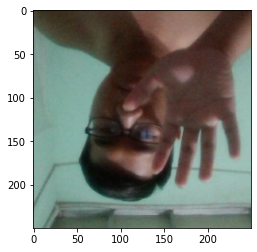

In [6]:
plt.imshow(train_images.as_numpy_iterator().next())
train_images.as_numpy_iterator().next().shape

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

2.2 Prepare Labels

In [8]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/Data_AI/Hand_Tracking/data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([0.6777, 0.787 ], dtype=float16),)

2.3. Combine Labels and Images

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.batch(16)
#train.as_numpy_iterator().next()[0].shape
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.batch(16)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.batch(16)
val = val.prefetch(4)

2.4 View Samples

In [15]:
data_samples = train.as_numpy_iterator()

In [16]:
res = data_samples.next()

array([0.6777, 0.787 ], dtype=float16)

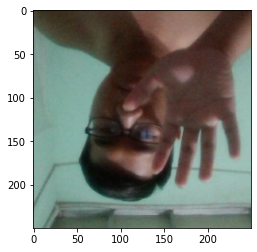

In [17]:
plt.imshow(res[0][0])
res[1][0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


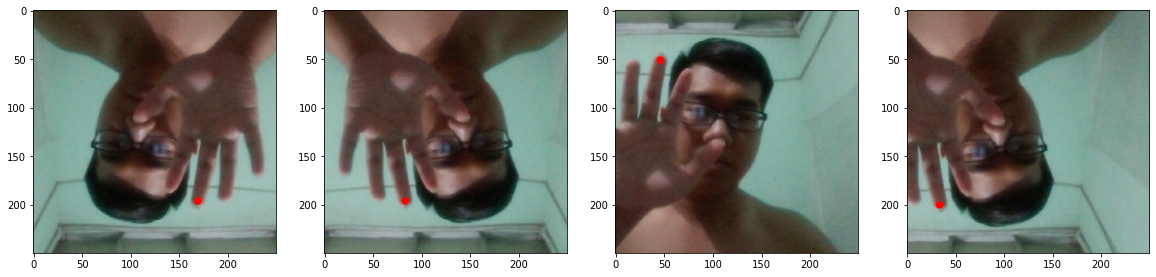

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 4, (255,0,0), -1)
    
    ax[idx].imshow(sample_image)

**3. Build Model**

3.1 Create Neural Network

In [19]:
from keras import datasets, Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [20]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(27,48),activation='relu',kernel_initializer='he_uniform',padding='same',input_shape=(250,250,3),strides=(9,16)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=64,kernel_size=(27,48), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu',input_shape=(250*250*3,), name='layer1')) 
model.add(Dense(512, activation='relu', name='layer2'))
model.add(Dense(512, activation='relu', name='layer3'))
model.add(Dense(2, activation='softmax', name='layer4'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 16, 32)        124448    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 8, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 8, 64)         2654272   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 layer1 (Dense)              (None, 512)               9

3.2 Setup Losses and Optimizer

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [23]:
model.compile(optimizer, loss)

3.3 Sense Check predictions

In [24]:
X, y = train.as_numpy_iterator().next()

In [25]:
X.shape

(16, 250, 250, 3)

In [26]:
scores = model.predict(X)

In [27]:
scores

array([[0.4996162 , 0.5003838 ],
       [0.49486992, 0.5051301 ],
       [0.4904628 , 0.5095372 ],
       [0.4880251 , 0.51197493],
       [0.48980284, 0.51019716],
       [0.49126044, 0.50873953],
       [0.49663863, 0.5033614 ],
       [0.4924443 , 0.5075557 ],
       [0.49556288, 0.5044371 ],
       [0.5005928 , 0.49940717],
       [0.489899  , 0.510101  ],
       [0.49686536, 0.50313467],
       [0.484454  , 0.51554596],
       [0.51107985, 0.48892012],
       [0.50366324, 0.49633673],
       [0.5064989 , 0.4935011 ]], dtype=float32)

3.4 Train the Model

In [30]:
# Train for 100 epochs

model.compile(optimizer,loss,metrics=[tf.keras.metrics.Accuracy()])               
history = model.fit(train, epochs=2, verbose=1)


Epoch 1/2
 3/64 [>.............................] - ETA: 5s - loss: 0.2836 - accuracy: 0.0000e+00

UnknownError: ignored

In [ ]:
model.save('Model.h5')

**4. Review Performance**

4.1 View Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

4.2. Make Predictions on Test

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

4.3. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')

In [ ]:
model = load_model('eyetrackerresnet.h5')

In [ ]:
model.predict(test_sample[0])